In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment import PricingEnvironment
from environments.joint_environment import JointEnvironment
from learners.joint.thompson_sampling_Joint import ThompsonSampling
from learners.pricing.ucb import UCB
from learners.joint.GPTS_Learner_v2_Joint import GPTS_Learner
from learners.joint.GTS_Learner_v2_Joint import GTS_Learner

In [3]:
##SIMULATION PARAMETERS
data_gen = BasicDataGenerator(filename='src/basic003.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

n_arms = len(prices)
env_params = {
        'mode': 'aggregate',
        'src': 'src/basic003.json'
}

T = 350
n_experiments = 4

print(15*'-','DATA', '-'*15)
print(f'prices={prices}')
print(f'bids={bids}')
print(f'margins={margins}')
print(f'conv_rates{conv_rates}')
print(f'cost_per_click={costs_per_click}')
print(f'n_clicks={n_clicks}')
print(f'aggr_tau={aggr_tau}')
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.3, 0.35, 0.4, 0.55, 0.6, 0.75, 0.9, 1.0, 1.25, 1.5]
margins=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
conv_rates[0.204 0.211 0.205 0.189 0.176 0.152 0.128 0.113 0.097 0.09 ]
cost_per_click=[0.294 0.342 0.389 0.529 0.576 0.713 0.847 0.935 1.151 1.361]
n_clicks=[115.248 124.161 131.72  148.684 152.973 163.133 170.442 174.226 181.125
 185.61 ]
aggr_tau=[2.85  2.485 2.12  1.755 1.39  1.025 0.84  0.69  0.65  0.65 ]

 --------------- SIMULATION PARAMS ---------------
Time horizon: 350 days
Num. experiments: 4


In [4]:
#Manually compute optimum for check
expected = []
for bid_id in range(0, len(bids)):
  for price_id in range(0, len(prices)):
    exp = n_clicks[bid_id] * (conv_rates[price_id] * margins[price_id] * (1 + aggr_tau[price_id]) - costs_per_click[bid_id])
    expected = np.append(expected, exp)
opt_val = np.max(expected)
print(f'Optimal val: {opt_val}')

Optimal val: 405.385505


In [5]:
rewards_per_experiment = []
gpts_rewards_per_experiment = []

for e in range(n_experiments):
    print(f'running experiment {e+1}/{n_experiments}...')
    test_instances = []
    ts_learner = ThompsonSampling(arm_values=margins)
    gpts_learner = GPTS_Learner(arms = bids)
    #gpts_learner = GTS_Learner(arms = bids)
    env = JointEnvironment(**env_params)

    for t in range(T):

        ts_learner.next_day()

        bidding_pulled_arm = gpts_learner.pull_arm()
        bidding_reward = env.bidding_round(bidding_pulled_arm)

        month_purchases = env.get_next_purchases_at_day(t, keep=False)
        if month_purchases is not None:
            pulled_arms = env.get_selected_arms_at_day(t - 30, keep=False)
            for arm, n_purchases in zip(pulled_arms, month_purchases):
                ts_learner.update_single_future_purchase(arm, n_purchases)
        pulled_arm = ts_learner.pull_arm()
        daily_reward = env.day_round(pulled_arm, bidding_reward['n_clicks'], bidding_reward['cpc'])
        #daily_reward = env.day_round(pulled_arm, n_clicks[3], costs_per_click[3])
        for outcome, cost in daily_reward:
            ts_learner.update(pulled_arm, outcome, cost)

        bidding_reward['tau'] = ts_learner.next_purchases_estimation[pulled_arm]
        bidding_reward['conv_rates'] = ts_learner.get_est_conv_rates()
        bidding_reward['margin'] = bidding_reward['margin'][pulled_arm]
        bidding_reward['conv_rates'] = bidding_reward['conv_rates'][pulled_arm]
        
        print(bidding_reward)
        gpts_learner.update(bidding_pulled_arm, bidding_reward)

    rewards_per_experiment.append(ts_learner.daily_collected_rewards)
    gpts_rewards_per_experiment.append(gpts_learner.daily_collected_rewards)

running experiment 1/4...
0
--------------- DATA IN ENV ---------------
None
conv_rates = [0.204 0.211 0.205 0.189 0.176 0.152 0.128 0.113 0.097 0.09 ]
taus = [2.85  2.485 2.12  1.755 1.39  1.025 0.84  0.69  0.65  0.65 ]
cpc = [0.294 0.342 0.389 0.529 0.576 0.713 0.847 0.935 1.151 1.361]
n_clicks=[115.248 124.161 131.72  148.684 152.973 163.133 170.442 174.226 181.125
 185.61 ]
margins=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
arm = 9; mean = 0.0; variance = 10.0
{'n_clicks': 184.93609841013608, 'cpc': 1.3704520935248112, 'margin': 12, 'tau': 0.0, 'conv_rates': 0.0962566844919786}
Info: -39.83003512437781
{'n_clicks': 184.93609841013608, 'cpc': 1.3704520935248112, 'margin': 12, 'tau': 0.0, 'conv_rates': 0.0962566844919786}
arm = 6; mean = 0.0; variance = 10.0
{'n_clicks': 170.9394873279986, 'cpc': 0.8618195511462183, 'margin': 10, 'tau': 0.0, 'conv_rates': 0.09248554913294797}
Info: 10.775331298165092
{'n_clicks': 170.9394873279986, 'cpc': 0.8618195511462183, 'margin': 10, 'tau': 0.0, 'conv_ra

In [6]:
#Get optimum from env
opt = env.get_opt()
print(f'combined opt arm n°{env.get_opt_arm()}')
print(f'combined opt = {opt}')

combined opt arm n°52
combined opt = 405.385505


In [7]:
rewards_per_experiment[0]

array([-49.5336373 ,   2.62885675,  64.15069371,  14.9096169 ,
        65.36023889,  66.23278918, 112.94912948,  58.24955676,
       -40.93221821, -24.75974089,  83.77560636,  53.98255186,
       152.17266228, 142.12509948, 101.47250567,  97.84469154,
       134.0865785 , 181.48177268, 134.42893209,  25.29349644,
        70.12617103,  93.28843608,  86.13917258, 109.58859749,
       133.76538344, 123.25848386, 103.95599738,  65.69519096,
       153.70238042,  42.92970658,  44.09814662, 191.38103407,
       191.34983192, 269.76630594, 244.31790355, 241.29944052,
       352.69783835, 463.33171621, 295.29907365, 407.04821561,
       263.45196554, 309.94456096, 366.79389506, 266.29491949,
       300.72268953, 301.67182216, 282.64427502, 333.42910063,
       334.01675767, 328.79450559, 491.20049877, 319.26155976,
       483.68455416, 284.81657345, 443.38520089, 351.06921358,
       450.29600529, 355.74322946, 390.86551603, 404.22143477,
       321.04201217, 261.86710684, 548.07074883, 354.00

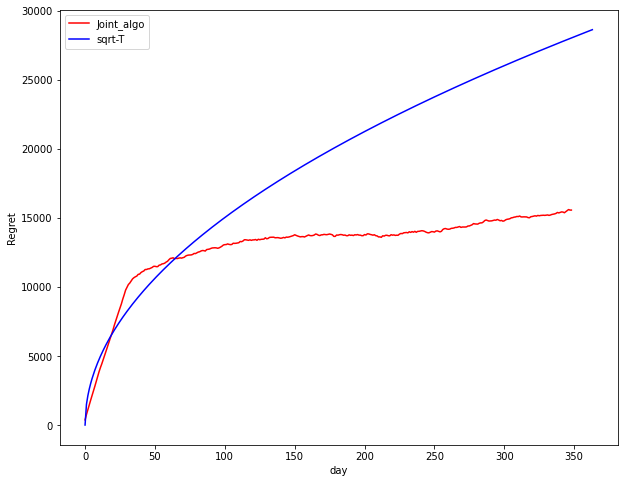

In [8]:
#Plot the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(np.cumsum(np.mean(opt - rewards_per_experiment, axis=0)), 'r')
plt.plot(1500*np.sqrt(np.linspace(0,364,364)), 'b')
plt.legend(['Joint_algo', 'sqrt-T'])
plt.show()

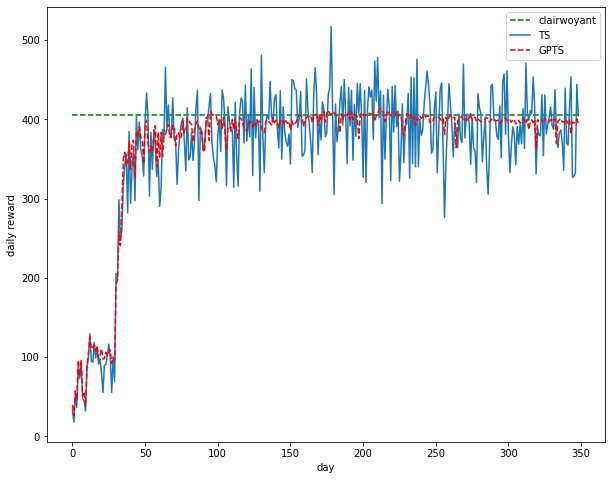

In [9]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*T, '--g', label='clairwoyant')
plt.plot(np.mean(rewards_per_experiment, axis=0), label='TS')
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0),'--r' ,label='GPTS')
plt.legend(loc='best')
plt.show()

In [10]:
#Check optimum indexes
for bid_idx in range(0, len(bids)):
    for price_idx in range(0, len(prices)):
                exp = n_clicks[bid_idx] * (conv_rates[price_idx] * margins[price_idx] * \
                       (1 + aggr_tau[price_idx]) - costs_per_click[bid_idx])
                if(exp == env.get_opt()):
                  print(f'bid idx = {bid_idx}')
                  print(f'price_idx = {price_idx}')

bid idx = 5
price_idx = 2


In [11]:
for i in gpts_learner.outcome_per_arm:
  print(len(i))

24
2
14
2
282
1
2
19
2
2


In [12]:
gpts_learner.outcome_per_arm

[[139.5472805173858,
  102.29131415813987,
  46.03220044062647,
  122.70413142732623,
  138.28837784990134,
  98.67075994950973,
  113.8472284126517,
  144.32290240119832,
  104.58605922285267,
  122.82879652956615,
  97.84554024969623,
  106.20664576531105,
  111.49630225869728,
  89.72142860446333,
  106.35571134723737,
  117.29322319746016,
  94.45051757991702,
  114.59267915154554,
  113.29952412764244,
  106.38737150850486,
  98.67882994825321,
  101.33731734275676,
  186.10726953094075,
  179.81376767944545],
 [90.17884075089626, 105.64459273837073],
 [294.18615141090964,
  414.2659972238325,
  352.7598887051099,
  365.6674882706817,
  358.59515822337954,
  358.7917740938486,
  343.10119837207816,
  348.3011690383852,
  260.85866953148394,
  366.8082241874931,
  351.1646609082279,
  365.809240177565,
  314.7358499305834,
  352.7094208396222],
 [107.74663309711222, 27.51490771421646],
 [378.3116178961765,
  331.9316330475359,
  360.59488816673985,
  382.7313952068929,
  386.473704

In [13]:
for i in ts_learner.outcome_per_arm:
  print(len(i))

729
940
28950
18070
934
1055
613
463
762
354


In [14]:
len(ts_learner.outcome_per_arm[2])

28950